In [1]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
from nilearn import plotting
import nibabel as nib
import itertools
from bold_dementia.connectivity import (
    Atlas, group_by_networks, plot_matrix, reshape_pvalues, block_block, plot_ordered_matrix
)
from bold_dementia.utils.iterables import unique

ATLAS = "msdl"
SOFT = True
ALPHA = config["alpha"]
atlas = Atlas.from_name(ATLAS, soft=SOFT)


In [2]:
expname = f"atlas-{ATLAS}_default_ols-cenanom"
matrices_path = Path(
    f"{config['output_dir']}/statresults/{expname}"
)
print(f"Loading matrices from {matrices_path}")
fdrmat = joblib.load(matrices_path / "pmat.joblib")
tstats = joblib.load(matrices_path / "statmap.joblib")

atlas = Atlas.from_name(ATLAS, soft=SOFT)
n_regions = len(atlas.labels)

thresholded_t = tstats * np.where(fdrmat < ALPHA, 1, 0)
labels = tuple(sorted(unique(atlas.macro_labels)))

Loading matrices from /homes_unix/jlegrand/data/Memento/output/statresults/atlas-msdl_default_ols-cenanom


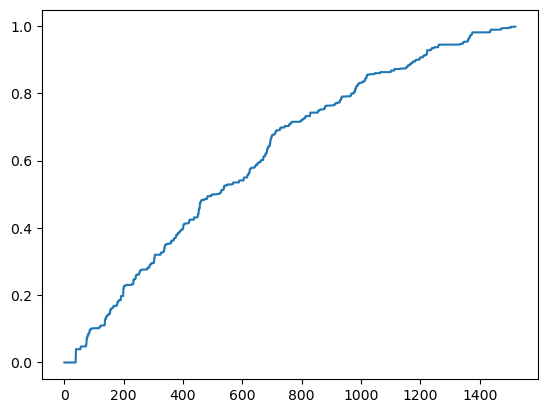

In [3]:
plt.plot(np.sort(fdrmat.flatten()))
plt.show()

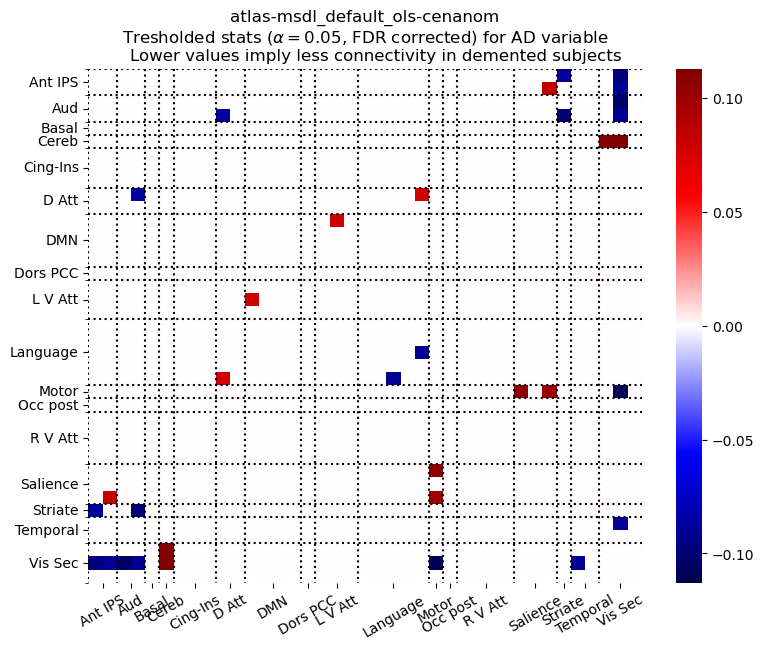

In [4]:
span = np.max(np.abs(thresholded_t))

if len(atlas.labels) < 35:
    plot_ordered_matrix(thresholded_t, atlas)
else:
    plot_matrix(thresholded_t, atlas)
plt.title(f"{expname}\nTresholded stats ($\\alpha = 0.05$, FDR corrected) for AD variable\n\
    Lower values imply less connectivity in demented subjects")
plt.show()

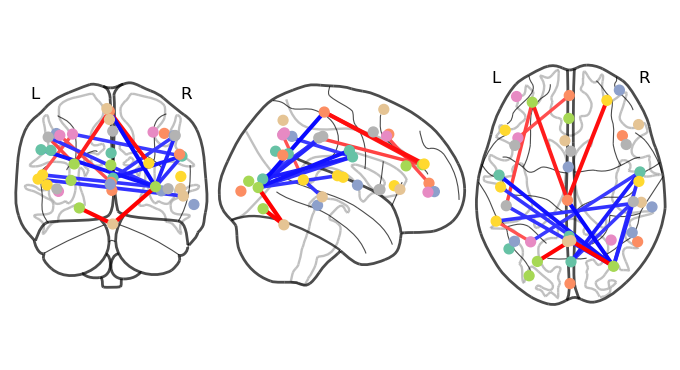

In [5]:
if ATLAS != "gillig":
    coords = atlas.get_coords()
    plotting.plot_connectome(
        thresholded_t, coords
    )
else:
    print("Not so iteresting to compute mass centers of networks obviously")


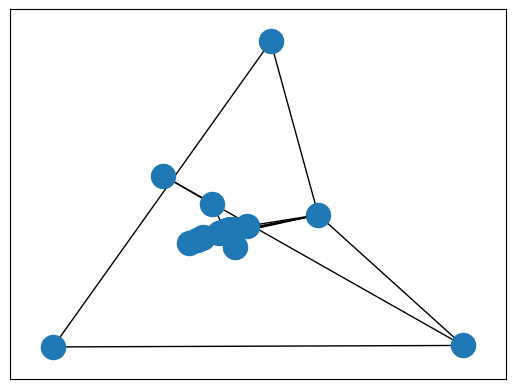

In [6]:
import networkx as nx

G = nx.from_numpy_array(thresholded_t, edge_attr="weight")

label_mapping = dict(zip(range(len(atlas.labels)), atlas.labels))

#pos = nx.spring_layout(G, seed=config["seed"], iterations=100)
pos = nx.spectral_layout(G)

nx.draw_networkx_nodes(G, pos)

nx.draw_networkx_edges(
    G,
    pos,
    edge_cmap="seismic"
)

#nx.draw_networkx_labels(
#    G,
#    pos,
#    font_size=8,
#    labels=label_mapping,
#)
plt.draw()

In [7]:
from bold_dementia.visualisation.chord_plot import make_links, create_chord
labels = atlas.labels_
matrix_df = pd.DataFrame(thresholded_t, index=labels, columns=labels)

links = make_links(matrix_df)

L Aud R LOC -0.10453475039295124 1.0453475039295124
R Aud Striate -0.10023953045990773 1.0023953045990772
R Aud L IPS -0.08705081542250655 0.8705081542250654
R Aud R LOC -0.09148350441785366 0.9148350441785367
Striate R Aud -0.10023953045990773 1.0023953045990772
Striate R Ant IPS -0.08768059862075955 0.8768059862075955
Front DMN L DLPFC 0.0784762501491824 0.784762501491824
Motor R LOC -0.10894579919433738 1.0894579919433738
Motor D ACC 0.10010776684352578 1.0010776684352578
Motor R A Ins 0.1064704075112143 1.064704075112143
L DLPFC Front DMN 0.0784762501491824 0.784762501491824
L IPS R Aud -0.08705081542250655 0.8705081542250654
L IPS L TPJ 0.076575256533363 0.76575256533363
Vis Cereb 0.11138368921540415 1.1138368921540414
R LOC L Aud -0.10453475039295124 1.0453475039295124
R LOC R Aud -0.09148350441785366 0.9148350441785367
R LOC Motor -0.10894579919433738 1.0894579919433738
R LOC L STS -0.08946529783211069 0.8946529783211068
R LOC Cereb 0.1128663550620253 1.128663550620253
R LOC L A

Text(0.5, 1.01, 'atlas-msdl_default_ols-cenanom\nTresholded slopes ($\\alpha = $0.05, FDR corrected)')

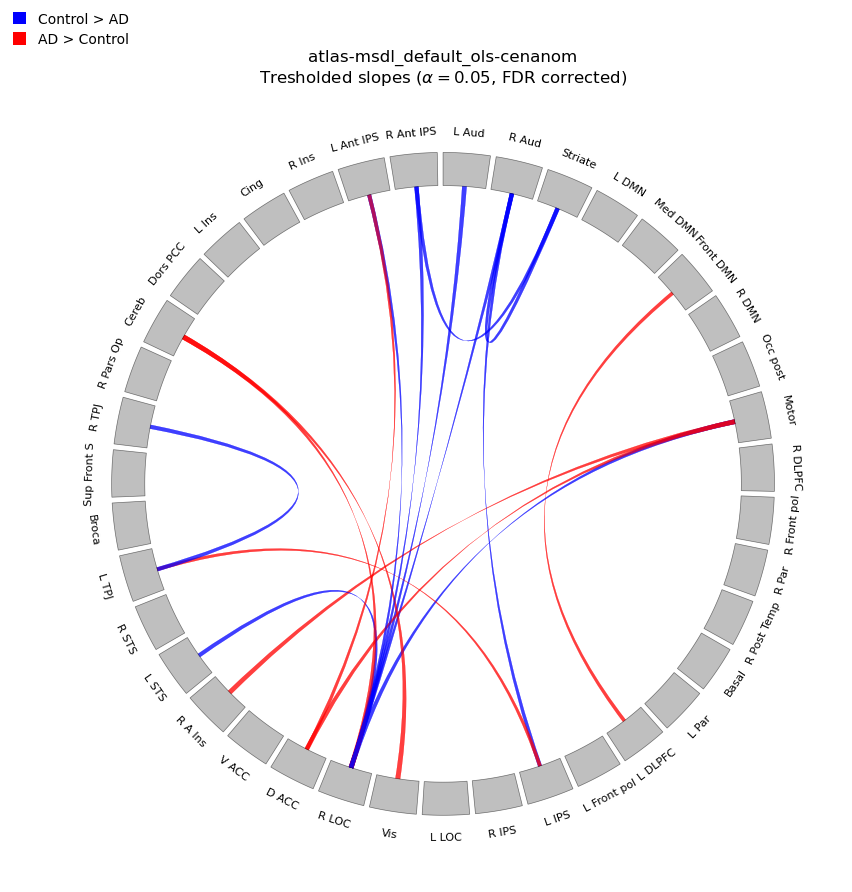

In [9]:
from bold_dementia.visualisation.chord_plot import create_chord
import matplotlib.patches as mpatches

blue_patch = mpatches.Patch(color='blue', label='Control > AD')
red_patch = mpatches.Patch(color='red', label='AD > Control')

networks = matrix_df.columns.to_list()
fig = create_chord(networks, links, size=8)
fig.legend(handles=[blue_patch, red_patch])
fig.suptitle(
    f"{expname}\nTresholded slopes ($\\alpha = ${ALPHA}, FDR corrected)",
    y=1.01
)